In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import Dropout
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np


### Ładowanie danych

In [3]:
def load_and_preprocess(file_path):
    data = pd.read_csv(file_path, parse_dates=['timestamp'])
    data = data.sort_values('timestamp').drop_duplicates('timestamp')
    return data

##### Isolation Forest

In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

# def dynamic_isolation_forest(data, column='energy_consumption', contamination_quantile=0.95, window_size=24):
#     scaler = MinMaxScaler()
#     values = scaler.fit_transform(data[[column]]).flatten()

#     # Utwórz sekwencje okien
#     sequences = create_sequences(values, window_size)

#     # Dopasuj IsolationForest na sekwencjach
#     model = IsolationForest(contamination='auto', random_state=42)
#     model.fit(sequences)
#     scores = model.decision_function(sequences)

#     # Ustal threshold na podstawie kwantyla
#     threshold = np.quantile(scores, 1 - contamination_quantile)
#     predicted = (scores < threshold).astype(int)

#     # Wskaźniki anomalii dla punktów oryginalnych
#     anomaly_scores = np.zeros(len(data))
#     counts = np.zeros(len(data))

#     # Głosowanie przez nakładające się okna
#     for i in range(len(predicted)):
#         if predicted[i] == 1:
#             anomaly_scores[i:i + window_size] += 1
#         counts[i:i + window_size] += 1

#     # Znormalizuj i oznacz anomalie, jeśli większość okien wskazuje na anomalię
#     avg_scores = np.divide(anomaly_scores, counts, out=np.zeros_like(anomaly_scores), where=counts != 0)
#     final_labels = (avg_scores > 0.5).astype(int)

#     data['isolation_forest'] = final_labels
#     return data

# def dynamic_isolation_forest(data, column='energy_consumption', window_size=24):
#     # Skalowanie danych
#     scaler = MinMaxScaler()
#     values = scaler.fit_transform(data[[column]]).flatten()

#     # Estymacja zanieczyszczenia (contamination) na podstawie IQR
#     q1, q3 = np.percentile(values, [25, 75])
#     iqr = q3 - q1
#     outlier_mask = (values < (q1 - 1.5 * iqr)) | (values > (q3 + 1.5 * iqr))
#     contamination = max(0.001, min(0.5, np.sum(outlier_mask) / len(values)))

#     # Tworzenie sekwencji (okien)
#     sequences = create_sequences(values, window_size)

#     # Trenowanie modelu
#     model = IsolationForest(contamination=contamination, random_state=42)
#     model.fit(sequences)

#     preds = model.predict(sequences)  # -1 dla anomalii, 1 dla normalnych
#     binary_preds = (preds == -1).astype(int)

#     # Głosowanie przez nakładające się okna
#     anomaly_scores = np.zeros(len(values))
#     counts = np.zeros(len(values))

#     for i in range(len(binary_preds)):
#         if binary_preds[i] == 1:
#             anomaly_scores[i:i+window_size] += 1
#         counts[i:i+window_size] += 1

#     # Średni wynik i klasyfikacja
#     avg_scores = np.divide(anomaly_scores, counts, out=np.zeros_like(anomaly_scores), where=counts != 0)
#     final_labels = (avg_scores > 0.5).astype(int)

#     # Zapisanie wyników
#     data['isolation_forest'] = final_labels
#     return data

def isolation_forest_95(data, column='energy_consumption', contamination_quantile=0.95):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])

    # Train initial model to get scores
    model = IsolationForest(contamination='auto')
    model.fit(values)
    scores = model.decision_function(values)  # The lower, the more abnormal

    # Estimate contamination based on quantile of scores
    threshold = np.quantile(scores, 1 - contamination_quantile)
    predicted = (scores < threshold).astype(int)

    data['isolation_forest'] = predicted
    return data

def isolation_forest_IQR(data, column='energy_consumption'):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])
    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    outlier_mask = (values < (q1 - 1.5 * iqr)) | (values > (q3 + 1.5 * iqr))
    outliers = values[outlier_mask]
    contamination = max(0.001, len(outliers) / len(values))
    model = IsolationForest(contamination=contamination)
    anomalies = model.fit_predict(values)
    data['isolation_forest'] = [1 if x == -1 else 0 for x in anomalies]
    return data


##### LSTM Autoencoder

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

def lstm_autoencoder(data, column='energy_consumption', window_size=24, iqr_multiplier=1.5, epochs=50, batch_size=32):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])

    # Tryb z całym ciągiem czasowym (brak okien)
    if window_size is None:
        X = values.reshape(1, values.shape[0], 1)  # Jedna próbka: cały szereg czasowy

        def build_model(hp):
            model = Sequential()
            model.add(LSTM(
                units=hp.Int('units', min_value=32, max_value=128, step=32),
                activation='relu',
                input_shape=(X.shape[1], 1),
                return_sequences=False))
            model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
            model.add(RepeatVector(X.shape[1]))
            model.add(LSTM(
                units=hp.Int('units', min_value=32, max_value=128, step=32),
                activation='relu',
                return_sequences=True))
            model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
            model.add(TimeDistributed(Dense(1)))
            model.compile(
                optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                loss='mse',
                metrics=['mae'])
            return model

        model = build_model(kt.HyperParameters())
        model.fit(X, X, epochs=epochs, batch_size=1, verbose=1)

        pred = model.predict(X)
        mae = np.mean(np.abs(pred - X), axis=(1, 2))[0]  # jedna próbka

        # Anomaly detection (globalna decyzja)
        data['lstm_autoencoder'] = 0
        data['reconstruction_error'] = np.abs(pred[0].squeeze() - X[0].squeeze())
        q1 = np.percentile(data['reconstruction_error'], 25)
        q3 = np.percentile(data['reconstruction_error'], 75)
        iqr = q3 - q1
        threshold = q3 + iqr_multiplier * iqr
        data['lstm_autoencoder'] = (data['reconstruction_error'] > threshold).astype(int)

        return data

    # Tryb z oknami
    else:
        if len(values) < window_size + 1:
            raise ValueError(f"Not enough data points ({len(values)}) for window size {window_size}")
        X = create_sequences(values, window_size)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        def build_model(hp):
            model = Sequential()
            model.add(LSTM(
                units=hp.Int('units', min_value=32, max_value=128, step=32),
                activation='relu',
                input_shape=(window_size, 1),
                return_sequences=False))
            model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
            model.add(RepeatVector(window_size))
            model.add(LSTM(
                units=hp.Int('units', min_value=32, max_value=128, step=32),
                activation='relu',
                return_sequences=True))
            model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
            model.add(TimeDistributed(Dense(1)))
            model.compile(
                optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                loss='mse',
                metrics=['mae'])
            return model

        tuner = kt.RandomSearch(
            build_model,
            objective='val_loss',
            max_trials=10,
            directory='tuning',
            project_name='energy_forecast'
        )

        tuner.search(X, X, epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1)
        best_model = tuner.get_best_models(num_models=1)[0]

        history = best_model.fit(X, X, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

        pred = best_model.predict(X)
        mae = np.mean(np.abs(pred - X), axis=(1, 2))

        q1 = np.percentile(mae, 25)
        q3 = np.percentile(mae, 75)
        iqr = q3 - q1
        threshold = q3 + iqr_multiplier * iqr

        anomalies = np.zeros(len(data))
        anomaly_scores = np.zeros(len(data))
        window_counts = np.zeros(len(data))

        for i in range(len(mae)):
            if mae[i] > threshold:
                anomaly_scores[i:i + window_size] += 1
            window_counts[i:i + window_size] += 1

        anomaly_scores = np.where(window_counts > 0, anomaly_scores / window_counts, 0)
        anomalies[anomaly_scores > 0.5] = 1

        data['lstm_autoencoder'] = anomalies
        data['reconstruction_error'] = np.nan
        data['reconstruction_error'].iloc[window_size - 1:] = mae

        return data


##### IQR

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def dynamic_iqr(timeseries, w=None, k=1.5):

    timeseries = pd.Series(timeseries).dropna().reset_index(drop=True)
    anomalies = np.zeros(len(timeseries), dtype=bool)

    if w is None or w >= len(timeseries):
        Q1 = timeseries.quantile(0.25)
        Q3 = timeseries.quantile(0.75)
        IQR = Q3 - Q1
        lb = Q1 - k * IQR
        ub = Q3 + k * IQR
        anomalies = (timeseries < lb) | (timeseries > ub)
    else:
        for i in range(len(timeseries)):
            start = max(0, i - w // 2)
            end = min(len(timeseries), i + w // 2)
            window = timeseries[start:end]
            Q1 = window.quantile(0.25)
            Q3 = window.quantile(0.75)
            IQR = Q3 - Q1
            lb = Q1 - k * IQR
            ub = Q3 + k * IQR
            if timeseries[i] < lb or timeseries[i] > ub:
                anomalies[i] = True

    return timeseries, anomalies


##### RUN

In [29]:

data = load_and_preprocess('anomaly_one_marked.csv')

data_lstm = data
IF_results = dynamic_isolation_forest(data=data)
LSTM_results = lstm_autoencoder(data_lstm)
timeseries, IQR_results = dynamic_iqr(data['energy_consumption'], w=24, k=1.5)

data2 = load_and_preprocess('anomaly_two_marked.csv')
data_lstm2 = data2
IF_results2 = dynamic_isolation_forest(data=data2)
LSTM_results2 = lstm_autoencoder(data_lstm2)
timeseries2, IQR_results2 = dynamic_iqr(data2['energy_consumption'], w=24, k=1.5)


data3 = load_and_preprocess('anomaly_three_marked.csv')
data_lstm3 = data3
IF_results3 = dynamic_isolation_forest(data=data3)
LSTM_results3 = lstm_autoencoder(data_lstm3)
timeseries3, IQR_results3 = dynamic_iqr(data3['energy_consumption'], w=24, k=1.5)


Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50


KeyboardInterrupt: 

In [26]:

data = load_and_preprocess('anomaly_one_marked.csv')
data_lstm = data
IF_results = isolation_forest_IQR(data=data)
IF_95_results = isolation_forest_95(data=data)
LSTM_results = lstm_autoencoder(data_lstm, window_size=None)
timeseries, IQR_results = dynamic_iqr(data['energy_consumption'], w=None, k=1.5)

data2 = load_and_preprocess('anomaly_two_marked.csv')
data_lstm2 = data2
IF_results2 = isolation_forest_IQR(data=data2)
IF_95_results2 = isolation_forest_95(data=data2)
LSTM_results2 = lstm_autoencoder(data_lstm2, window_size=None)
timeseries2, IQR_results2 = dynamic_iqr(data2['energy_consumption'], w=None, k=1.5)


data3 = load_and_preprocess('anomaly_three_marked.csv')
data_lstm3 = data3
IF_results3 = isolation_forest_IQR(data=data3)
IF_95_results3 = isolation_forest_95(data=data3)
LSTM_results3 = lstm_autoencoder(data_lstm3, window_size=None)
timeseries3, IQR_results3 = dynamic_iqr(data3['energy_consumption'], w=None, k=1.5)

Epoch 1/50


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


: 

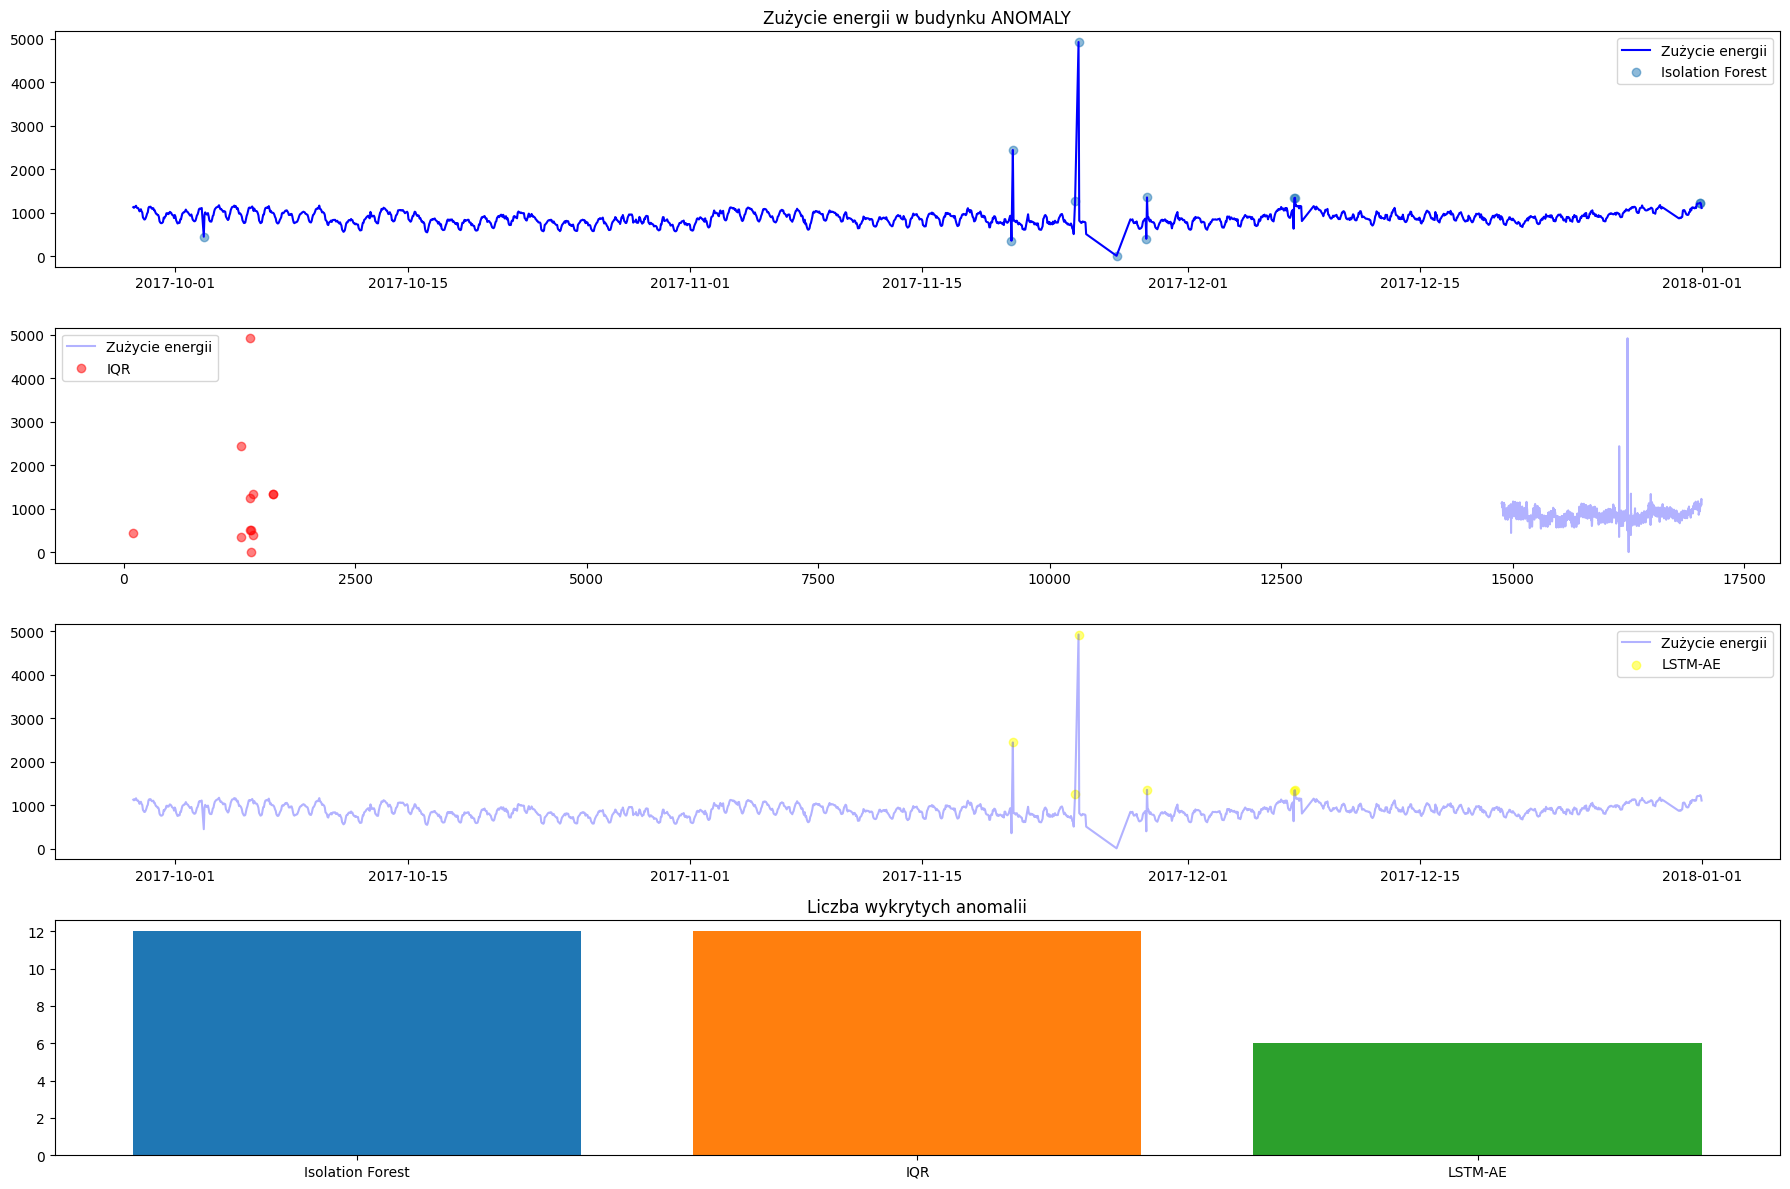

In [23]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseries[IQR_results].index, timeseries[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_results['timestamp'][LSTM_results['lstm_autoencoder'] == 1], LSTM_results['energy_consumption'][LSTM_results['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF = IF_results[IF_results['isolation_forest'] == 1].count()
counts_IQR = timeseries[IQR_results].count()
counts_LSTM = LSTM_results[LSTM_results['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF)
plt.bar('IQR', counts_IQR)
plt.bar('LSTM-AE', counts_LSTM)
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

In [24]:
print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseries[IQR_results].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries[IQR_results].index)) - c}")

c = 0

for i in list(IF_results[IF_results['isolation_forest'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results[IF_results['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2[IQR_results2].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2[IQR_results2].index)) - c}")

c = 0

for i in list(IF_results2[IF_results2['isolation_forest'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2[IF_results2['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3[IQR_results3].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3[IQR_results3].index)) - c}")

c = 0

for i in list(IF_results3[IF_results3['isolation_forest'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3[IF_results3['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 0/9
Liczba anomalii wykrytych przez IQR spoza zakresu: 12
Liczba anomalii wykrytych przez IF: 6/9
Liczba anomalii wykrytych przez IF spoza zakresu: 6
Liczba anomalii wykrytych przez LSTM-AE: 2/9
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 4
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 0/27
Liczba anomalii wykrytych przez IQR spoza zakresu: 17
Liczba anomalii wykrytych przez IF: 16/27
Liczba anomalii wykrytych przez IF spoza zakresu: 1
Liczba anomalii wykrytych przez LSTM-AE: 11/27
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 0
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 0/9
Liczba anomalii wykrytych przez IQR spoza zakresu: 6
Liczba anomalii wykrytych przez IF: 6/9
Liczba anomalii wykrytych przez IF spoza zakresu: 0
Liczba anomalii wykrytych przez LSTM-AE: 4/9
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 0


--- ANOMALY 1

Liczba anomalii wykrytych przez IQR: 24/39\
Liczba anomalii wykrytych przez IQR spoza zakresu: 9\
Liczba anomalii wykrytych przez IF: 39/39\
Liczba anomalii wykrytych przez IF spoza zakresu: 131\
Liczba anomalii wykrytych przez LSTM-AE: 36/39\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 439

--- ANOMALY 2

Liczba anomalii wykrytych przez IQR: 20/51\
Liczba anomalii wykrytych przez IQR spoza zakresu: 0\
Liczba anomalii wykrytych przez IF: 51/51\
Liczba anomalii wykrytych przez IF spoza zakresu: 70\
Liczba anomalii wykrytych przez LSTM-AE: 49/51\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 579

--- ANOMALY 3

Liczba anomalii wykrytych przez IQR: 38/62\
Liczba anomalii wykrytych przez IQR spoza zakresu: 8\
Liczba anomalii wykrytych przez IF: 62/62\
Liczba anomalii wykrytych przez IF spoza zakresu: 54\
Liczba anomalii wykrytych przez LSTM-AE: 49/62\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 796

=========== Wyniki budynek 1 ===========\
Liczba anomalii wykrytych przez IQR: 34/39\
Liczba anomalii wykrytych przez IQR spoza zakresu: 132\
Liczba anomalii wykrytych przez IF: 39/39\
Liczba anomalii wykrytych przez IF spoza zakresu: 802\
Liczba anomalii wykrytych przez LSTM-AE: 38/39\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 688

=========== Wyniki budynek 2 ===========\
Liczba anomalii wykrytych przez IQR: 30/51\
Liczba anomalii wykrytych przez IQR spoza zakresu: 10\
Liczba anomalii wykrytych przez IF: 51/51\
Liczba anomalii wykrytych przez IF spoza zakresu: 549\
Liczba anomalii wykrytych przez LSTM-AE: 47/51\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 841

=========== Wyniki budynek 3 ===========\
Liczba anomalii wykrytych przez IQR: 50/62\
Liczba anomalii wykrytych przez IQR spoza zakresu: 40\
Liczba anomalii wykrytych przez IF: 62/62\
Liczba anomalii wykrytych przez IF spoza zakresu: 330\
Liczba anomalii wykrytych przez LSTM-AE: 57/62\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 803

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

data = [
    ("IQR", "I", 34, 5, 132, 16871),
    ("IQR", "II", 30, 21, 10, 11999),
    ("IQR", "III", 50, 12, 40, 7721),
    ("IF z percentylem 0.95", "I", 39, 0, 802, 16201),
    ("IF z percentylem 0.95", "II", 51, 0, 549, 11460),
    ("IF z percentylem 0.95", "III", 62, 0, 330, 7431),

    ("IF z IQR", "I", 38, 1, 3, 12018),
    ("IF z IQR", "II", 44, 7, 17, 11992),
    ("IF z IQR", "III", 62, 0, 85, 7676),
    
    ("LSTM-AE", "I", 38, 1, 761, 16242),
    ("LSTM-AE", "II", 50, 1, 819, 11190),
    ("LSTM-AE", "III", 49, 13, 769, 6992),
]

df = pd.DataFrame(data, columns=["Model", "Budynek", "TP", "FN", "FP", "TN"])

df["Precision"] = df["TP"] / (df["TP"] + df["FP"])
df["Recall"] = df["TP"] / (df["TP"] + df["FN"])
df["F1-score"] = 2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"])
df["Accuracy"] = (df["TP"] + df["TN"]) / (df["TP"] + df["TN"] + df["FP"] + df["FN"])

df_metrics_1 = df[["Model", "Budynek", "Precision", "Recall", "F1-score", "Accuracy"]].round(4)
df_metrics_1

,Model,Budynek,Precision,Recall,F1-score,Accuracy
0,IQR,I,0.2048,0.8718,0.3317,0.9920
1,IQR,II,0.7500,0.5882,0.6593,0.9974
2,IQR,III,0.5556,0.8065,0.6579,0.9934
3,IF z percentylem 0.95,I,0.0464,1.0000,0.0886,0.9529
4,IF z percentylem 0.95,II,0.0850,1.0000,0.1567,0.9545
5,IF z percentylem 0.95,III,0.1582,1.0000,0.2731,0.9578
6,IF z IQR,I,0.9268,0.9744,0.9500,0.9997
7,IF z IQR,II,0.7213,0.8627,0.7857,0.9980
8,IF z IQR,III,0.4218,1.0000,0.5933,0.9891
9,LSTM-AE,I,0.0476,0.9744,0.0907,0.9553


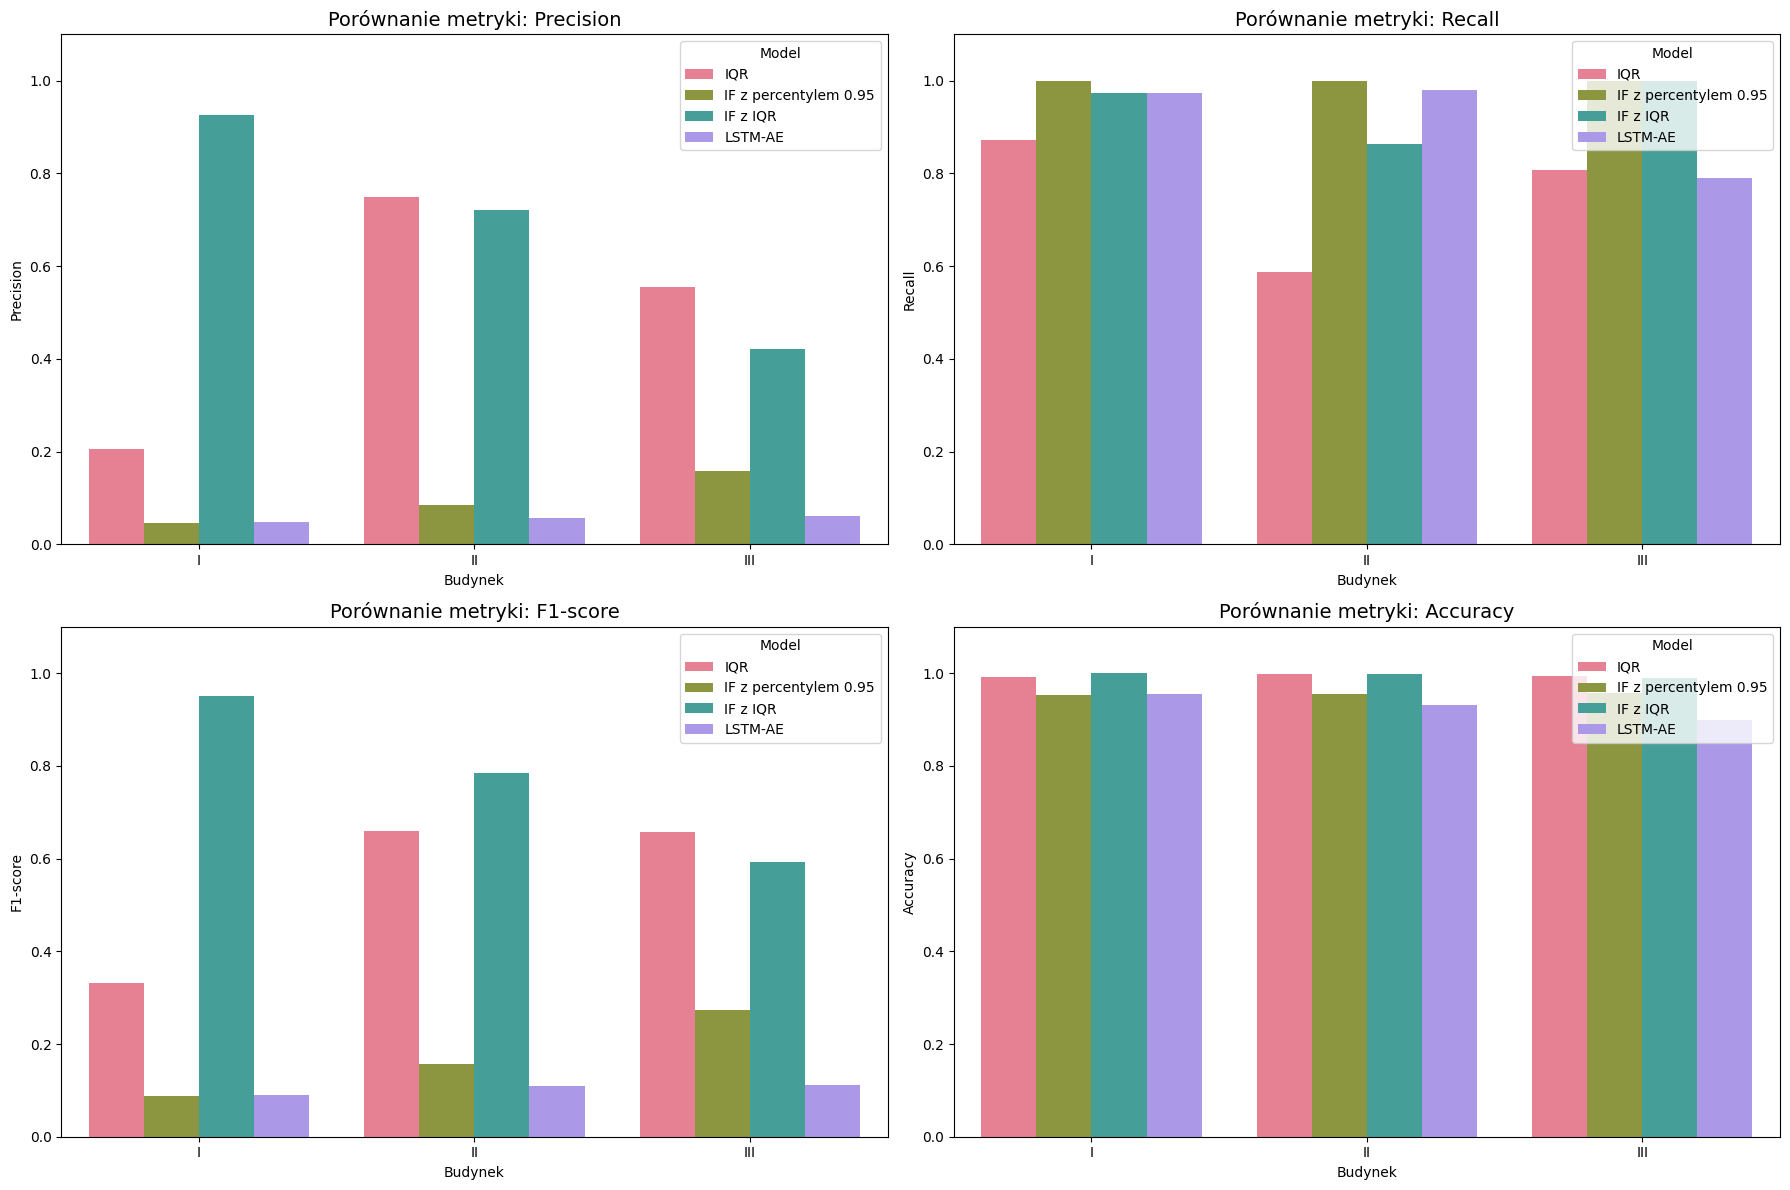

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df1 = pd.DataFrame(df_metrics_1, columns=['Model', 'Budynek', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
df1['Tabela'] = 'Tabela 1'

metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
unique_models = df1['Model'].unique()
palette = sns.color_palette("husl", len(unique_models))
model_colors = dict(zip(unique_models, palette))

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    df_sorted = df1.copy()
    df_sorted['sort_key'] = df_sorted.groupby('Budynek')[metric].rank(ascending=False, method='first')
    df_sorted = df_sorted.sort_values(by=['Budynek', 'sort_key'])
    df_sorted.reset_index(drop=True, inplace=True)
    
    sns.barplot(
        data=df_sorted,
        x='Budynek',
        y=metric,
        hue='Model',
        ax=ax,
        errorbar=None,
        dodge=True,
        palette=model_colors,
        hue_order=unique_models
    )
    
    ax.set_title(f'Porównanie metryki: {metric}', fontsize=14)
    ax.set_ylabel(metric)
    ax.set_xlabel('Budynek')
    ax.set_ylim(0, 1.1)
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Model')

plt.tight_layout()
plt.show()